# Creating synthetic models for fault classification

This notebook illustrates how to use the software in the velocity directory of this repo to create synthetic models for fault classification

## Define parameters of model

I first define the parameters of the model that will be created using the model building program. With the defined parameters, I can create the model building object that will be used to create each feature of the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import velocity.mdlbuild as mdlbuild
from scaas.wavelet import ricker
from utils.ptyprint import progressbar
import utils.rand as rndut

# Dimensions of the model
nz = 1000; dz = 12.0
nx = 1000; dx = 25.0
ny = 20;   dy = 25.0; slcy = 10

# Model building object
mb = mdlbuild.mdlbuild(nx,dx,ny,dy,dz,basevel=5000)

Next I define the number of layers and the parameters for the velocity gradient as well as the thicknesses of the layers

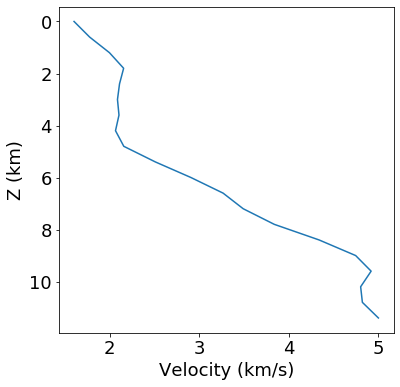

In [2]:
nlayer = 20
minvel = 1600; maxvel = 5000
props = mb.vofz(nlayer,minvel,maxvel)
thicks = np.random.randint(40,61,nlayer)

# Plot the v(z) gradient
fsize = 18
fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)
dlayer = ((nz-1)*dz)/nlayer
z = np.linspace(0.0,(nlayer-1)*dlayer,nlayer)
ax.plot(np.flip(props/1000.0),z/1000.0)
ax.set_xlabel('Velocity (km/s)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.invert_yaxis()
plt.show()

Next I determine at which point of the deposition I desire to fold the layers. The first argument controls the number of layers to fold and the last determined the minimum spacing between the layers to be folded

In [3]:
sqlyrs = sorted(mb.findsqlyrs(3,nlayer,5))
print("Folding lyrs %d, %d and %d"%(sqlyrs[0],sqlyrs[1],sqlyrs[2]))

Folding lyrs 4, 9 and 19


## Create a folded model
I first create a midly-folded model that has the velocity gradient shown in the figure above. To do this I use the deposit and squish functions within model build.

ndeposit: [########################################] 20/20


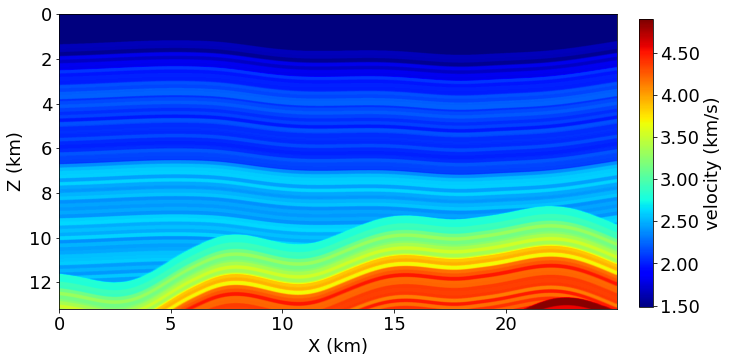

In [4]:
# Loop over all deposits to create the model
csq = 0
for ilyr in progressbar(range(nlayer), "ndeposit:", 40):
    mb.deposit(velval=props[ilyr],thick=thicks[ilyr],layer=150,layer_rand=0.00,dev_layer=0.1)
    # Random folding
    if(ilyr in sqlyrs):
        if(sqlyrs[csq] < 15):
            # Random amplitude variation in the folding
            amp = np.random.rand()*(3000-500) + 500 
            mb.squish(amp=amp,azim=90.0,lam=0.4,rinline=0.0,rxline=0.0,mode='perlin')
        elif(sqlyrs[csq] >= 15 and sqlyrs[csq] < 18):
            amp = np.random.rand()*(1800-500) + 500 
            mb.squish(amp=amp,azim=90.0,lam=0.4,rinline=0.0,rxline=0.0,mode='perlin')
        else:
            amp = np.random.rand()*(500-300) + 300
            mb.squish(amp=amp,azim=90.0,lam=0.4,rinline=0.0,rxline=0.0,mode='perlin')
        csq += 1

# Water deposit
mb.deposit(1480,thick=50,layer=150,dev_layer=0.0)

# Smooth any unfconformities
mb.smooth_model(rect1=1,rect2=5,rect3=1)

# Trim model before faulting
mb.trim(0,nz+100)

fig = plt.figure(2,figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow((mb.vel[slcy,:,:]/1000.0).T,cmap='jet',extent=[0,(nx-1)*dx/1000.0,(nz+100-1)*dz/1000.0,0.0],
               interpolation='bilinear')
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
ax.tick_params(labelsize=fsize)
cbar_ax = fig.add_axes([0.93,0.3,0.02,0.4])
cbar = fig.colorbar(im,cbar_ax,format='%.2f')
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('velocity (km/s)',fontsize=fsize)
plt.show()

## Adding faults to the folded model
I now add many faults to this folded model. I add larger faults at the bottom of the model, and gradually increase the fault size with depth. The relative position of the fault will in the end not matter for the neural network, but it can affect the imaging.

nlfaults: [########################################] 4/4
nmfaults: [########################################] 3/3
nsfaults: [########################################] 9/9
ntfaults: [########################################] 6/6


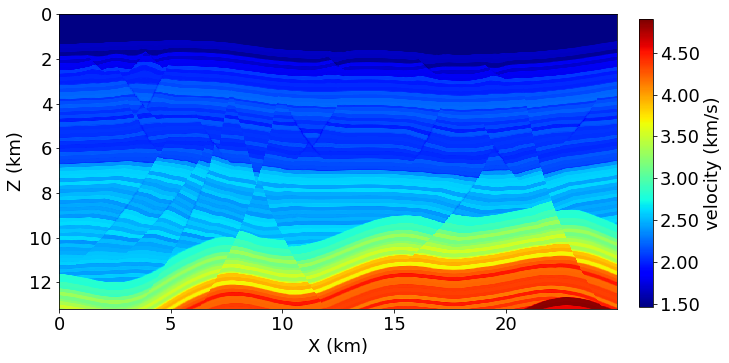

In [5]:
# Fault it up!
azims = [0.0,180.0]
fprs  = [True,False]

# Large faults
nlf = np.random.randint(2,5)
for ifl in progressbar(range(nlf), "nlfaults:", 40):
    azim = np.random.choice(azims)
    fpr  = np.random.choice(fprs)
    xpos = rndut.randfloat(0.1,0.9)
    mb.largefault(azim=azim,begz=0.65,begx=xpos,begy=0.5,dist_die=2.0,tscale=6.0,fpr=fpr,twod=True)

# Medium faults
nmf = np.random.randint(3,6)
for ifl in progressbar(range(nmf), "nmfaults:", 40):
    azim = np.random.choice(azims)
    fpr  = np.random.choice(fprs)
    xpos = rndut.randfloat(0.05,0.95)
    mb.mediumfault(azim=azim,begz=0.65,begx=xpos,begy=0.5,dist_die=2.0,tscale=3.0,fpr=fpr,twod=True)

# Small faults (sliding or small)
nsf = np.random.randint(5,10)
for ifl in progressbar(range(nsf), "nsfaults:", 40):
    azim = np.random.choice(azims)
    xpos = rndut.randfloat(0.05,0.95)
    zpos = rndut.randfloat(0.2,0.5)
    mb.smallfault(azim=azim,begz=zpos,begx=xpos,begy=0.5,dist_die=2.0,tscale=2.0,fpr=fpr,twod=True)

# Tiny faults
ntf = np.random.randint(5,10)
for ifl in progressbar(range(ntf), "ntfaults:", 40):
    azim = np.random.choice(azims)
    xpos = rndut.randfloat(0.05,0.95)
    zpos = rndut.randfloat(0.15,0.3)
    mb.tinyfault(azim=azim,begz=zpos,begx=xpos,begy=0.5,dist_die=2.0,tscale=2.0,fpr=fpr,twod=True)

# Plot the faulted model
fig = plt.figure(3,figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow((mb.vel/1000.0).T,cmap='jet',extent=[0,(nx-1)*dx/1000.0,(nz+100-1)*dz/1000.0,0.0])
ax.set_xlabel('X (km)',fontsize=fsize)
ax.set_ylabel('Z (km)',fontsize=fsize)
ax.tick_params(labelsize=fsize)
cbar_ax = fig.add_axes([0.93,0.3,0.02,0.4])
cbar = fig.colorbar(im,cbar_ax,format='%.2f')
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('velocity (km/s)',fontsize=fsize)
plt.show()

## Model processing
Now with the created velocity model, I can reshape the model to the output I want (512 x 1024) and also compute the reflectivity and a zero-offset image by taking a vertical derivative and then convolving with a wavelet.

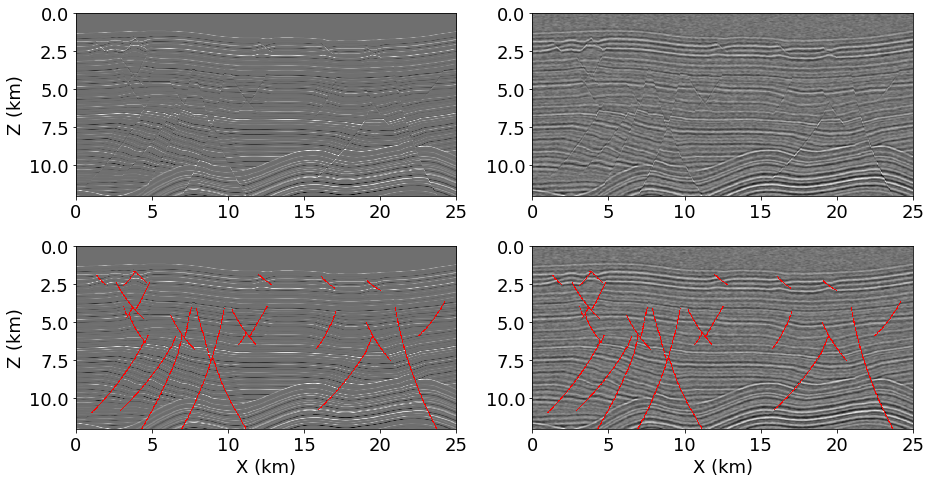

In [6]:
import deeplearn.utils as dlut
from scipy.ndimage import gaussian_filter
from utils.signal import bandpass

## Resize the outputs
nzo = 512; nxo = 1024
# Get model
vel = gaussian_filter(mb.vel[:,:nz],sigma=0.5).astype('float32')
lbl = mb.get_label2d()[:,:nz]

velr = dlut.resample(vel,[nxo,nzo],kind='quintic')
lblr = dlut.thresh(dlut.resample(lbl,[nxo,nzo],kind='linear'),0)
refr = mb.calcrefl2d(velr)

## Create a fake image
# Ricker wavelet parameters
nt = 250; ot = 0.0; dt = 0.001; ns = int(nt/2)
amp = 1.0; dly = 0.125
minf = 60.0; maxf = 100.0
# Compute ricker wavelet with random frequency 
f = rndut.randfloat(minf,maxf)
wav = ricker(nt,dt,f,amp,dly)

# Convolve with reflectivity
img = dlut.normalize(np.array([np.convolve(refr[ix,:],wav) for ix in range(nxo)])[:,ns:nzo+ns])
# Create noise
nze = dlut.normalize(bandpass(np.random.rand(nxo,nzo)*2-1, 2.0, 0.01, 2, pxd=43))/rndut.randfloat(3,5)
img += nze

## Plot reflectivity and image with labels
f,axarr = plt.subplots(2,2,figsize=(15,15))
# Reflectivity
axarr[0,0].imshow(refr.T,cmap='gray',extent=[0,(nx)*dx/1000.0,(nz)*dz/1000.0,0.0])
axarr[0,0].set_ylabel('Z (km)',fontsize=fsize)
axarr[0,0].tick_params(labelsize=fsize)
# Image
axarr[0,1].imshow(img.T,cmap='gray',extent=[0,(nx)*dx/1000.0,(nz)*dz/1000.0,0.0])
axarr[0,1].tick_params(labelsize=fsize)
# Create mask
mask = np.ma.masked_where(lblr == 0, lblr)
cmap = colors.ListedColormap(['red','white'])
# Reflectivity with label
axarr[1,0].imshow(refr.T,cmap='gray',extent=[0,nx*dx/1000.0,(nz)*dz/1000.0,0.0])
axarr[1,0].imshow(mask.T,cmap,extent=[0,(nx)*dx/1000.0,(nz)*dz/1000.0,0.0])
axarr[1,0].set_xlabel('X (km)',fontsize=fsize)
axarr[1,0].set_ylabel('Z (km)',fontsize=fsize)
axarr[1,0].tick_params(labelsize=fsize)
# Image with label
axarr[1,1].imshow(img.T,cmap='gray',extent=[0,(nx)*dx/1000.0,(nz)*dz/1000.0,0.0])
axarr[1,1].imshow(mask.T,cmap,extent=[0,(nx)*dx/1000.0,(nz)*dz/1000.0,0.0])
axarr[1,1].set_xlabel('X (km)',fontsize=fsize)
axarr[1,1].tick_params(labelsize=fsize)
plt.subplots_adjust(hspace=-0.6)
plt.show()